In [9]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [10]:
mycountry = ['VNM']
peers = ['CHN', 'LAO', 'THA', 'AGO', 'MMR', 'UZB', 'WSM']
allcountries = peers + mycountry

In [53]:
df1 = pd.read_csv('H0_5Y_1.csv')
df2 = pd.read_csv('H0_5Y_2.csv')
df = df1.append(df2)
df = df.drop('Unnamed: 0', axis=1)
df.head()

,year,exporter,commoditycode,export_value
0,1995,ABW,0101,17100.0
1,1995,ABW,0102,0.0
2,1995,ABW,0103,0.0
3,1995,ABW,0104,0.0
4,1995,ABW,0105,0.0


In [14]:
HS = pd.DataFrame(df.commoditycode.unique())
HS.columns = ['commoditycode']
HS.head()

,commoditycode
0,0101
1,0102
2,0103
3,0104
4,0105


In [15]:
#import HS to NAICS concordance
NAICS = pd.read_csv('HS_NAICS.csv')
NAICS = NAICS.drop('Unnamed: 0', axis=1)
NAICS.columns = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm']
NAICS.index = HS['commoditycode'][0:-2]
NAICS.head()

,a,b,c,d,e,f,g,h,i,j,k,l,m
commoditycode,,,,,,,,,,,,,
0101,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0102,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0103,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0104,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0105,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
test = pd.DataFrame(NAICS.stack())
test = test.loc[test[0] != '.']
test = test.loc[test[0] != np.nan]
test = test.loc[test[0] != 'NaN']
test = test.reset_index()
test = test.drop('level_1', axis=1)
test.head()

,commoditycode,0
0,0210,311920
1,0702,327212
2,0710,339913
3,0710,331491
4,0711,331491


In [17]:
test2 = test.merge(df, on='commoditycode', how='outer')
test2.columns = ['hs', 'naics', 'year', 'exporter', 'export_value']
test2 = test2.dropna()
test2.head()

,hs,naics,year,exporter,export_value
0,0210,311920,1995,AGO,0.0
1,0210,311920,1995,CHN,20968958.0
2,0210,311920,1995,LAO,2643.0
3,0210,311920,1995,MMR,18313.0
4,0210,311920,1995,THA,437879.0


In [18]:
test2['counter'] = 1
test2['naics_count'] = test2.groupby(['exporter', 'year', 'hs'])['counter'].transform(sum)
test2['export_1'] = test2.groupby(['exporter', 'year', 'naics', 'hs'])['export_value'].transform(sum)
test2['export_1'] = test2['export_1'] / test2['naics_count']
test2['export_2'] = test2.groupby(['exporter', 'year', 'naics'])['export_1'].transform(sum)
test2 = test2.drop_duplicates(['exporter', 'year', 'naics'])
test2 = test2.sort_values(['year', 'exporter', 'naics'])
test2.head()

,hs,naics,year,exporter,export_value,counter,naics_count,export_1,export_2
7384,2106,311920,1995,AGO,0.0,1,8,0.000000,0.000000
41008,6211,315234,1995,AGO,1195.0,1,8,149.375000,149.375000
31288,4819,322214,1995,AGO,3393.0,1,9,377.000000,377.000000
25008,3926,326220,1995,AGO,6698.0,1,9,744.222222,744.222222
80008,9403,327212,1995,AGO,215922.0,1,8,26990.250000,26990.250000


In [19]:
naics_ex = test2.drop(['hs', 'export_value', 'counter', 'naics_count', 'export_1'], axis=1)
naics_ex = naics_ex.reset_index()
naics_ex = naics_ex.drop('index', axis=1)
naics_ex.columns = ['naics', 'year', 'exporter', 'export_value']
naics_ex['naics'] = naics_ex['naics'].astype(str)
naics_ex.head()

,naics,year,exporter,export_value
0,311920.0,1995,AGO,0.000000
1,315234.0,1995,AGO,149.375000
2,322214.0,1995,AGO,377.000000
3,326220.0,1995,AGO,744.222222
4,327212.0,1995,AGO,26990.250000


In [20]:
IDlist = naics_ex['naics'].unique()
len(IDlist)

454

In [55]:
concord = pd.read_csv('NAICS_BEA.csv')
concord['long_naics'] = np.nan

for i in range(0, len(concord)):
        templen = len(str(concord['NAICS Code'][i]))
        for j in IDlist:
            this = j
            if this[0:templen] == str(concord['NAICS Code'][i]):
                concord.loc[i,'long_naics'] = this

concord = concord.drop(['Title', 'NAICS Code'],axis=1)
concord.columns = ['BEA', 'naics']
concord = concord.dropna()
concord.head()

,BEA,naics
0,1111A0,111110
1,1111A0,111120
3,1111B0,111140
4,1111B0,111150
5,1111B0,111160


In [22]:
BEA_ex = concord.merge(naics_ex, on='naics', how='outer')
BEA_ex = BEA_ex.dropna()
BEA_ex = BEA_ex.sort_values(['exporter', 'year', 'BEA'])
BEA_ex['export_agg'] = BEA_ex.groupby(['exporter', 'year', 'BEA'])['export_value'].transform(sum)
BEA_ex = BEA_ex.drop(['export_value', 'naics'], axis=1)
BEA_ex = BEA_ex.drop_duplicates(['exporter', 'year', 'BEA'])
BEA_ex['export_tot'] = BEA_ex.groupby(['exporter', 'year'])['export_agg'].transform(sum)
BEA_ex['export_share'] = BEA_ex['export_agg'] / BEA_ex['export_tot']
BEA_ex['log_export'] = np.log(BEA_ex['export_agg']+1)
BEA_ex = BEA_ex.drop(['export_agg', 'export_tot'], axis=1)

BEA_ex.head()

,BEA,year,exporter,export_share,log_export
240,111200,1995,AGO,0.000000,0.000000
280,111300,1995,AGO,0.000000,0.000000
320,111400,1995,AGO,0.000000,0.000000
360,111900,1995,AGO,0.000000,0.000000
480,113000,1995,AGO,0.000442,13.496206


In [70]:
#get US 2007 input output data
usa = pd.read_csv('input_output.csv')
usa = usa.fillna(0)
usa = usa.loc[usa.Code.isin(['221100', '517110', '482000', '484000'])]
usa = usa.drop('Commodity Description', axis=1)
usa = usa.set_index('Code')
usa = usa.transpose()
usa = usa.reset_index()
usa.columns = ['BEA', 'electricity', 'rail', 'truck', 'internet']
usa['electricity'] = usa['electricity'] / usa['electricity'].max()
usa['rail'] = usa['rail'] / usa['rail'].max()
usa['truck'] = usa['truck'] / usa['truck'].max()
usa['internet'] = usa['internet'] / usa['internet'].max()
usa.head()

,BEA,electricity,rail,truck,internet
0,1111A0,0.001503,0.0,0.000588,0.000258
1,1111B0,0.003714,0.0,0.010970,0.000746
2,111200,0.002009,0.0,0.003134,0.000115
3,111300,0.001907,0.0,0.003722,0.000115
4,111400,0.000506,0.0,0.000000,0.000172


In [71]:
regress = BEA_ex.merge(usa, on='BEA', how='outer')
regress = regress.dropna()
regress = regress.sort_values(['exporter', 'year', 'BEA'])
regress = regress.join(pd.get_dummies(regress['exporter']))
regress = regress.join(pd.get_dummies(regress['BEA']))
regress = regress.drop(['BEA', 'exporter'], axis=1)
regress['year'] = regress['year'].astype(int)
regress.head()

,year,export_share,log_export,electricity,rail,truck,internet,AGO,CHN,LAO,...,33391A,33399A,33399B,33411A,33441A,33451A,3363A0,33641A,33712A,33721A
8080,1995,0.000000,0.000000,0.001503,0.0,0.000588,0.000258,1,0,0,...,0,0,0,0,0,0,0,0,0,0
8120,1995,0.000000,0.000000,0.003714,0.0,0.010970,0.000746,1,0,0,...,0,0,0,0,0,0,0,0,0,0
8160,1995,0.000013,9.934914,0.001315,0.0,0.007052,0.000172,1,0,0,...,0,0,0,0,0,0,0,0,0,0
8200,1995,0.000000,0.000000,0.006459,0.0,0.000000,0.000287,1,0,0,...,0,0,0,0,0,0,0,0,0,0
8240,1995,0.000013,9.954323,0.005101,0.0,0.000000,0.000947,1,0,0,...,0,0,0,0,0,0,0,0,0,0


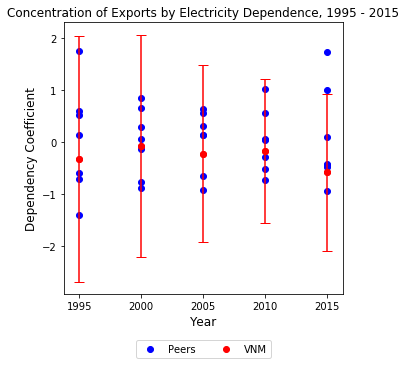

In [72]:
#electricity
elec = regress.drop(['rail', 'truck', 'internet'],axis = 1)
varlist = []
mycvar = 'elec_' + mycountry[0]
for i in allcountries:
    elec['elec_' + i] = elec['electricity'] * elec[i]
    varlist.append('elec_' + i)
elec = elec.drop('electricity', axis=1)

elec_out = pd.DataFrame(columns=['ID', 'mean', 'error'])

for n in [1995, 2000, 2005, 2010, 2015]:
    elec_n = elec.loc[elec['year'] == n]
    elec_n = elec_n.drop('year', axis=1)
    X = elec_n.drop('export_share', axis=1)
    X = sm.add_constant(X)
    Y = elec_n['export_share']
    model = sm.OLS(Y, X).fit()
    elec_n = model.conf_int()
    elec_n.columns = ['lower', 'upper']
    elec_n = elec_n.join(pd.DataFrame(model.params))
    elec_n = elec_n.loc[elec_n.index.isin(varlist)]
    elec_n = elec_n.sort_values([0], ascending=False)
    elec_n['year'] = n
    elec_n = elec_n.reset_index()
    elec_n['error'] = elec_n['upper'] - elec_n[0]
    elec_n = elec_n.drop(['lower', 'upper'], axis=1)
    elec_n.columns = ['ID', 'mean', 'year', 'error']
    elec_out = elec_out.append(elec_n)

fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(elec_out.loc[elec_out.ID != mycvar]['year'], elec_out.loc[elec_out.ID != mycvar]['mean'], c="blue")
ax.scatter(elec_out.loc[elec_out.ID == mycvar]['year'], elec_out.loc[elec_out.ID == mycvar]['mean'], c="red")
(_, caps, _) = ax.errorbar(elec_out.loc[elec_out.ID == mycvar]['year'], elec_out.loc[elec_out.ID == mycvar]['mean'], yerr=elec_out.loc[elec_out.ID == mycvar]['error'], fmt='o', capsize=5, c="red")
for cap in caps:
    cap.set_markeredgewidth(1)
ax.legend(['Peers', mycountry[0]], loc=9, bbox_to_anchor=(0.5, -0.15), ncol=2)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Dependency Coefficient', fontsize=12)
plt.title('Concentration of Exports by Electricity Dependence, 1995 - 2015')
plt.show()

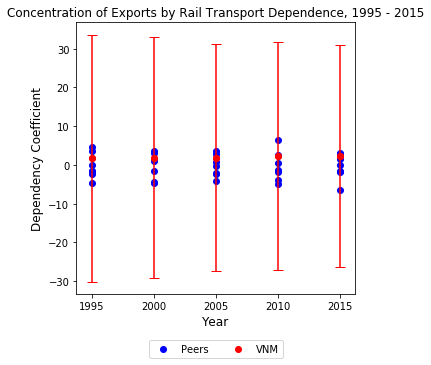

In [26]:
#rail
rail = regress.drop(['electricity', 'truck', 'internet'],axis = 1)
varlist = []
mycvar = 'rail_' + mycountry[0]
for i in allcountries:
    rail['rail_' + i] = rail['rail'] * rail[i]
    varlist.append('rail_' + i)
rail = rail.drop('rail', axis=1)

rail_out = pd.DataFrame(columns=['ID', 'mean', 'error'])

for n in [1995, 2000, 2005, 2010, 2015]:
    rail_n = rail.loc[rail['year'] == n]
    rail_n = rail_n.drop('year', axis=1)
    X = rail_n.drop('export_share', axis=1)
    X = sm.add_constant(X)
    Y = rail_n['export_share']
    model = sm.OLS(Y, X).fit()
    rail_n = model.conf_int()
    rail_n.columns = ['lower', 'upper']
    rail_n = rail_n.join(pd.DataFrame(model.params))
    rail_n = rail_n.loc[rail_n.index.isin(varlist)]
    rail_n = rail_n.sort_values([0], ascending=False)
    rail_n['year'] = n
    rail_n = rail_n.reset_index()
    rail_n['error'] = rail_n['upper'] - rail_n[0]
    rail_n = rail_n.drop(['lower', 'upper'], axis=1)
    rail_n.columns = ['ID', 'mean', 'year', 'error']
    rail_out = rail_out.append(rail_n)

fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(rail_out.loc[rail_out.ID != mycvar]['year'], rail_out.loc[rail_out.ID != mycvar]['mean'], c="blue")
ax.scatter(rail_out.loc[rail_out.ID == mycvar]['year'], rail_out.loc[rail_out.ID == mycvar]['mean'], c="red")
(_, caps, _) = ax.errorbar(rail_out.loc[rail_out.ID == mycvar]['year'], rail_out.loc[rail_out.ID == mycvar]['mean'], yerr=rail_out.loc[rail_out.ID == mycvar]['error'], fmt='o', capsize=5, c="red")
for cap in caps:
    cap.set_markeredgewidth(1)
ax.legend(['Peers', mycountry[0]], loc=9, bbox_to_anchor=(0.5, -0.15), ncol=2)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Dependency Coefficient', fontsize=12)
plt.title('Concentration of Exports by Rail Transport Dependence, 1995 - 2015')
plt.show()

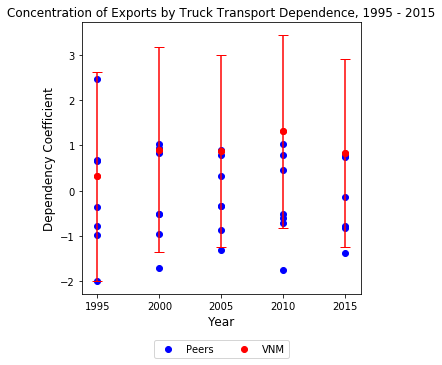

In [28]:
#truck
truck = regress.drop(['electricity', 'rail', 'internet'],axis = 1)
varlist = []
mycvar = 'truck_' + mycountry[0]
for i in allcountries:
    truck['truck_' + i] = truck['truck'] * truck[i]
    varlist.append('truck_' + i)
truck = truck.drop('truck', axis=1)

truck_out = pd.DataFrame(columns=['ID', 'mean', 'error'])

for n in [1995, 2000, 2005, 2010, 2015]:
    truck_n = truck.loc[truck['year'] == n]
    truck_n = truck_n.drop('year', axis=1)
    X = truck_n.drop('export_share', axis=1)
    X = sm.add_constant(X)
    Y = truck_n['export_share']
    model = sm.OLS(Y, X).fit()
    truck_n = model.conf_int()
    truck_n.columns = ['lower', 'upper']
    truck_n = truck_n.join(pd.DataFrame(model.params))
    truck_n = truck_n.loc[truck_n.index.isin(varlist)]
    truck_n = truck_n.sort_values([0], ascending=False)
    truck_n['year'] = n
    truck_n = truck_n.reset_index()
    truck_n['error'] = truck_n['upper'] - truck_n[0]
    truck_n = truck_n.drop(['lower', 'upper'], axis=1)
    truck_n.columns = ['ID', 'mean', 'year', 'error']
    truck_out = truck_out.append(truck_n)

fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(truck_out.loc[truck_out.ID != mycvar]['year'], truck_out.loc[truck_out.ID != mycvar]['mean'], c="blue")
ax.scatter(truck_out.loc[truck_out.ID == mycvar]['year'], truck_out.loc[truck_out.ID == mycvar]['mean'], c="red")
(_, caps, _) = ax.errorbar(truck_out.loc[truck_out.ID == mycvar]['year'], truck_out.loc[truck_out.ID == mycvar]['mean'], yerr=truck_out.loc[truck_out.ID == mycvar]['error'], fmt='o', capsize=5, c="red")
for cap in caps:
    cap.set_markeredgewidth(1)
ax.legend(['Peers', mycountry[0]], loc=9, bbox_to_anchor=(0.5, -0.15), ncol=2)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Dependency Coefficient', fontsize=12)
plt.title('Concentration of Exports by Truck Transport Dependence, 1995 - 2015')
plt.show()

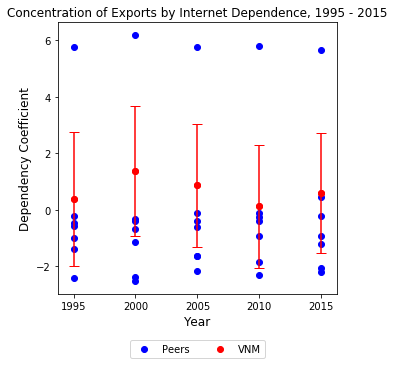

In [31]:
#internet
internet = regress.drop(['electricity', 'rail', 'truck'],axis = 1)
varlist = []
mycvar = 'internet_' + mycountry[0]
for i in allcountries:
    internet['internet_' + i] = internet['internet'] * internet[i]
    varlist.append('internet_' + i)
internet = internet.drop('internet', axis=1)

internet_out = pd.DataFrame(columns=['ID', 'mean', 'error'])

for n in [1995, 2000, 2005, 2010, 2015]:
    internet_n = internet.loc[internet['year'] == n]
    internet_n = internet_n.drop('year', axis=1)
    X = internet_n.drop('export_share', axis=1)
    X = sm.add_constant(X)
    Y = internet_n['export_share']
    model = sm.OLS(Y, X).fit()
    internet_n = model.conf_int()
    internet_n.columns = ['lower', 'upper']
    internet_n = internet_n.join(pd.DataFrame(model.params))
    internet_n = internet_n.loc[internet_n.index.isin(varlist)]
    internet_n = internet_n.sort_values([0], ascending=False)
    internet_n['year'] = n
    internet_n = internet_n.reset_index()
    internet_n['error'] = internet_n['upper'] - internet_n[0]
    internet_n = internet_n.drop(['lower', 'upper'], axis=1)
    internet_n.columns = ['ID', 'mean', 'year', 'error']
    internet_out = internet_out.append(internet_n)

fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(internet_out.loc[internet_out.ID != mycvar]['year'], internet_out.loc[internet_out.ID != mycvar]['mean'], c="blue")
ax.scatter(internet_out.loc[internet_out.ID == mycvar]['year'], internet_out.loc[internet_out.ID == mycvar]['mean'], c="red")
(_, caps, _) = ax.errorbar(internet_out.loc[internet_out.ID == mycvar]['year'], internet_out.loc[internet_out.ID == mycvar]['mean'], yerr=internet_out.loc[internet_out.ID == mycvar]['error'], fmt='o', capsize=5, c="red")
for cap in caps:
    cap.set_markeredgewidth(1)
ax.legend(['Peers', mycountry[0]], loc=9, bbox_to_anchor=(0.5, -0.15), ncol=2)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Dependency Coefficient', fontsize=12)
plt.title('Concentration of Exports by Internet Dependence, 1995 - 2015')
plt.show()